In [6]:
import numpy as np
import imageio as io
import scipy
from scipy import stats
import matplotlib.pyplot as plt

In [20]:
def clipping(img):
    
    img[img > 255] = 255
    img[img < 0] = 0
    return img

In [11]:
def disp(denoising_mode, m, local=False, dispn=None):
#     print(m)
    if denoising_mode == "average":
        d = np.std(m)
    elif denoising_mode == "robust":
        q75, q25 = np.percentile(m, [75 ,25])
        d = q75 - q25 
        
    if d == 0:
        d = 1 if not local else dispn
    
    return d 

In [12]:
def centr(m):
    if denoising_mode == "average":
        return np.mean(m)
    elif denoising_mode == "robust":
        return np.median(m)  

In [26]:
def ADF(img, gamma, denoising_mode, coord_disp, n):
    
    
    
    # 2. Calculate image's dispersion
    # 2.1 Calculate dispn, a fixed value 
    dispn = disp(denoising_mode, img[coord_disp[0]:coord_disp[1], coord_disp[2]:coord_disp[3]])
    
    # 1. Pad the image
    img = np.pad(img, (n,n), 'symmetric')
    
    M, N = img.shape
    
    # 2.2. Create an empty image
    img_n = np.zeros((M-2*n,N-2*n)).astype(np.uint8)
    
    # 2.3. Loop over the empty image filling it with the new values
    for x in range(n, M-n):
        for y in range(n, N-n):
            displ = disp(denoising_mode, img[x-n:x+n, y-n:y+n], local=True, dispn=dispn)
            img_n[x-n,y-n] = img[x,y] - gamma*(dispn/displ)*(img[x,y] - centr(img[x-n:x+n, y-n:y+n]))
    
    return img_n
    

In [59]:
def gaussian_filter(k=3, sigma = 1.0):
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp ( -(1/2)*( np.square( x ) + np.square(y) ) / np.square(sigma))
    return filt/np.sum(filt)

In [163]:
def CLSF(g, gamma, k, sigma):
    M, N = g.shape
    P = M
    Q = N
    
    # 1. Convert the degraded image to the frequency domain
    
#     img_pad = np.pad(g, (((Q - N)//2, Q-N-(Q - N)//2), ((P - M)//2, P-M-(P - M)//2)), "constant", constant_values=0)
    f_g = scipy.fft.rfft2(g)
#     print(f_g.imag)
    
    # 2. Create the gaussian filter and convert it to the frequency domain
    h = gaussian_filter(k=k, sigma = sigma)
#     h_pad = np.pad(h, (((Q - k)//2, Q-k-(Q - k)//2), ((P - k)//2, P-k-(P - k)//2)), "constant", constant_values=0)
    h_pad = np.pad(h, ((P-k-(P - k)//2, (P - k)//2), (Q-k-(Q - k)//2, (Q - k)//2)), "constant", constant_values=0)
#     plt.figure()
#     plt.imshow(h_pad) 
#     plt.show()
#     print(h)
#     print(h_pad)
    f_h = scipy.fft.rfft2(h_pad)
    
    # 3. Create p and convert it to the frequency domain
    p = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    p_pad = np.pad(p, ((Q-3-(Q - 3)//2, (Q - 3)//2), (P-3-(P - 3)//2, (P - 3)//2)), "constant", constant_values=0) 
#     print(p)
    f_p = scipy.fft.rfft2(p_pad)
    
#     print(g.shape, h_pad.shape, p_pad.shape)
#     print(f_g.shape, f_h.shape, f_p.shape)
    
    # 4. Compute f hat in frequency domain
    f_hat = (np.conj(f_h) / (f_h**2 + gamma*(f_p**2)) )*f_g
    
    
    # 5. Convert f_hat to spatial domain
    f_hat = scipy.fft.irfft2(f_hat)
    f_hat = np.fft.fftshift(f_hat)
    f_hat = f_hat[(Q - N)//2:(Q - N)//2+N, (P - M)//2:(P - M)//2+M]
    
#     print(f_hat.shape)
#     print(f_hat)
    
    return f_hat

    
    
    
    

In [175]:
def CLSF(g, gamma, k, sigma):
    M, N = g.shape
    P = M
    Q = N
    
    # 1. Convert the degraded image to the frequency domain
    f_g = scipy.fft.rfft2(g)
    
    # 2. Create the gaussian filter and convert it to the frequency domain
    h_pad = np.pad(gaussian_filter(k=k, sigma = sigma), ((P-k-(P - k)//2, (P - k)//2), (Q-k-(Q - k)//2, (Q - k)//2)), "constant", constant_values=0)
    f_h = scipy.fft.rfft2(h_pad)
    
    # 3. Create p and convert it to the frequency domain
    p = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    p_pad = np.pad(p, ((Q-3-(Q - 3)//2, (Q - 3)//2), (P-3-(P - 3)//2, (P - 3)//2)), "constant", constant_values=0) 
    f_p = scipy.fft.rfft2(p_pad)
    
    # 4. Compute f hat in frequency domain
    f_hat = (np.conj(f_h) / (f_h**2 + gamma*(f_p**2)) )*f_g
        
    # 5. Convert f_hat to spatial domain
    f_hat = scipy.fft.irfft2(f_hat)
    f_hat = np.fft.fftshift(f_hat)
    f_hat = f_hat[(Q - N)//2:(Q - N)//2+N, (P - M)//2:(P - M)//2+M]
    
    
    return f_hat

    
    
    
    

In [22]:
def RSE(g, R):
	assert g.shape == R.shape
	M, N = g.shape
	return np.sqrt(np.sum((g-R)**2)/(M*N))

In [15]:
# case1 5.392600407980945
# Path to the images. It is an user's input
reference_name = "input_images/polygons128.png"
degraded_name = "input_images/case1_10.png"

# Type of the filter
F = 1

# Gama parametr
gamma = 0.15

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 20] 
    n = 5
    denoising_mode = "average" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
# else:
#     k = 
#     delta = 

In [134]:
# case2 21.875998861123463
# Path to the images. It is an user's input
reference_name = "input_images/polygons128.png"
degraded_name = "input_images/case2_45.png"

# Type of the filter
F = 1

# Gama parametr
gamma = 0.95

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 20] 
    n = 5
    denoising_mode = "robust" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
# else:
#     k = 
#     delta = 

In [24]:
# case3 22.21161211822827
# Path to the images. It is an user's input
reference_name = "input_images/moon_small.jpg"
degraded_name = "input_images/case3_70.png"

# Type of the filter
F = 1

# Gama parametr
gamma = 0.8

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 30] 
    n = 3
    denoising_mode = "robust" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
# else:
#     k = 
#     delta = 

In [34]:
# case4 20.17474964085773
# Path to the images. It is an user's input
reference_name = "input_images/moon_small.jpg"
degraded_name = "input_images/case3_70.png"

# Type of the filter
F = 1

# Gama parametr
gamma = 1.0

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 30] 
    n = 3
    denoising_mode = "average" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
# else:
#     k = 
#     delta = 

In [165]:
# polygons128.png
# case5_5_1.png
# 2
# 0.00005
# 5
# 1.0

#case5 - 6.477146761945513
# Path to the images. It is an user's input
reference_name = "input_images/polygons128.png"
degraded_name = "input_images/case5_5_1.png"

# Type of the filter
F = 2

# Gama parametr
gamma = 0.00005

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 30] 
    n = 3
    denoising_mode = "average" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
else:
    k = 5
    sigma = 1.0
    result = CLSF(deg_image, gamma, k, sigma)


In [168]:
# polygons128.png
# case6_3_1.png
# 2
# 0.02
# 3
# 1.0



#case6 - 36.97933547863464
# Path to the images. It is an user's input
reference_name = "input_images/polygons128.png"
degraded_name = "input_images/case6_3_1.png"

# Type of the filter
F = 2

# Gama parametr
gamma = 0.02

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 30] 
    n = 3
    denoising_mode = "average" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
else:
    k = 3
    sigma = 1.0
    result = CLSF(deg_image, gamma, k, sigma)


In [170]:
# moon.jpg
# case7_7_125.png
# 2
# 0.00008
# 7
# 1.25



#case7 - 3.6887928910639673
# Path to the images. It is an user's input
reference_name = "input_images/moon.jpg"
degraded_name = "input_images/case7_7_125.png"

# Type of the filter
F = 2

# Gama parametr
gamma = 0.00008

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 30] 
    n = 3
    denoising_mode = "average" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
else:
    k = 7
    sigma = 1.25
    result = CLSF(deg_image, gamma, k, sigma)


In [176]:
# moon.jpg
# case8_3_15.png
# 2
# 0.008
# 3
# 1.6




#case7 - 13.31402607798533
# Path to the images. It is an user's input
reference_name = "input_images/moon.jpg"
degraded_name = "input_images/case8_3_15.png"

# Type of the filter
F = 2

# Gama parametr
gamma = 0.008

ref_image = io.imread(reference_name)
deg_image = io.imread(degraded_name)

if F == 1:
    coord_disp = [0, 20, 0, 30] 
    n = 3
    denoising_mode = "average" 
    result = ADF(deg_image, gamma, denoising_mode, coord_disp, n)
else:
    k = 3
    sigma = 1.6
    result = CLSF(deg_image, gamma, k, sigma)


13.31402607798533


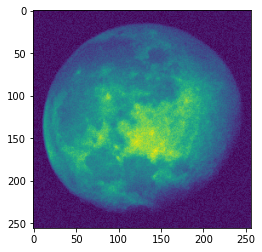

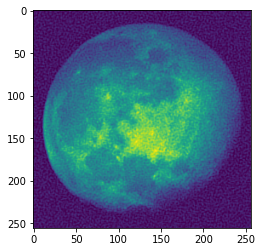

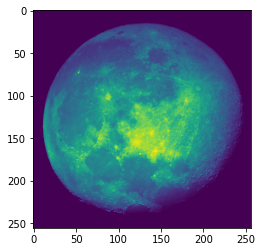

In [177]:
# 1 ok 
# 2 ok
# 3 ok
# 4 ok 
# 5 ok
# 6 ok
# 7 ok
# 8 ok

result = clipping(result)
error = RSE(result.astype(np.int32), ref_image)
print(error)

plt.figure()
plt.imshow(deg_image) 
plt.show()

plt.figure()
plt.imshow(result) 
plt.show()

plt.figure()
plt.imshow(ref_image) 
plt.show()
